In [1]:
import dm_event
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize


from scipy.interpolate import CubicSpline

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({'font.size': 20})
#from importlib import reload
#reload(dm_event)

Welcome to JupyROOT 6.22/07


In [ ]:
nxbin = 1
nybin = 10
totrows = 6144
totcols = 4128 #6160
nx = 636
ny = 840
mass_ccd = 8.8952e-3
n_images = 38
masked_fraction = 0#(2+0.25)/100
exposuremass = n_images*mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  # grams
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 22583.2/86400*24
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 40)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### CCD 3
noise = 1.572
print(t_exp)
dcmm2days = (7.8/t_exp+1.7)+20
dc = dcmm2days*(15*15)*1e-6
mu0 = -0.160

lam = dc*t_exp*nxbin*nybin
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))

#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 4
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

df = pd.read_csv("cumulativePCD_7x7x50x150_amp_L_v1.csv", header=None)
events = df[0]
npix = len(events)
texp=22583.2/86400 #days
mass_det = npix*3.507e-9 #kg
print("{} g*days".format(mass_det*texp*1000))
print(npix)



for i,m in enumerate(mass_x):
    print("------Mass {} MeV-------".format(m*1e-6))
    for j in range(n_reps):
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        
        dm.events = events
        dm.npix = npix
        dm.texp = texp #days
        dm.mass_det = dm.mass_det
        
        dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-2,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,1,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        
        dm.events = events
        dm.npix = npix
        dm.texp = texp #days
        dm.mass_det = dm.mass_det        
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_1[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,2,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        
        dm.events = events
        dm.npix = npix
        dm.texp = texp #days
        dm.mass_det = dm.mass_det
        
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_2[i][j] = dm.cross_section_dLL

        """
        plt.hist(dm.events, bins = 10, density = False)
        dm = dm_event.dm_event(14, 14, m, dm.cross_section_95, 0.6, 1, True, Eemin=0.06, Eemax=Eemax, eff="efficiency_DAMIC.csv")
        dm.plot_var("dRdE")
        plt.loglog()
        plt.xlim(0.06,1)
        plt.ylim(1e-3,1e2)
        plt.show()
        """
        
    df_inf = pd.read_csv("DAMICSNOLAB_q0.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Paper Limit $q=0$", linewidth=4,alpha=0.6)
    
            
    df_inf = pd.read_csv("DAMICSNOLAB_q1.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="b", label=r"Paper Limit $q=1$", linewidth=4,alpha=0.6)
    
                
    df_inf = pd.read_csv("DAMICSNOLAB_q2.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="k", label=r"Paper Limit $q=2$", linewidth=4, alpha=0.6)
    
    
    #df_sup = pd.read_csv("DAMICS_sup.csv", comment="#")
    #x2,y2 = df_sup["mx"],df_sup["xs"]

    #plt.plot(x1,y1, 'o',label="DAMICM Upper Limit Papers")
    #plt.fill(
    #    np.append(x1, x2[::-1]),
    #    np.append(y1, y2[::-1]), color="r", alpha = 0.6, label="DAMIC Paper"
    #)

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")

    xs_mean = np.median(xs_1, axis=1)
    xs_std = np.std(xs_1, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "b")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=1", alpha = 0.4, color = "b")

 
    xs_mean = np.median(xs_2, axis=1)
    xs_std = np.std(xs_2, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "k")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=2", alpha = 0.4, color = "k")

 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-36,1e-27)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

6.2731111111111115
Total Exposure [g*days]:  1.8610436444362013
0.26137962962962963
Dark Current [e/pix*days]:  0.011596871745368236
Dark Current [e/pix_binned*days]:  0.11596871745368235
Dark Current [e/pix_binned*img]:  0.030311860416666662
Dark Current [e/mm2*img]:  13.471937962962961
39.71121593905608 g*days
43321719
------Mass 0.6 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  1.8610436444362013
Number of Total Pixels:  43321719
Number of Signal events:  0


# Upper limit SI

27.77777777777778
Total Exposure [g*days]:  156.67601365943204
1.1574074074074074
Dark Current [e/pix*days]:  0.0063988199999999995
Dark Current [e/pix_binned*days]:  0.639882
Dark Current [e/pix_binned*img]:  0.7406041666666666
Dark Current [e/mm2*img]:  32.915740740740745
------Mass 0.6 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


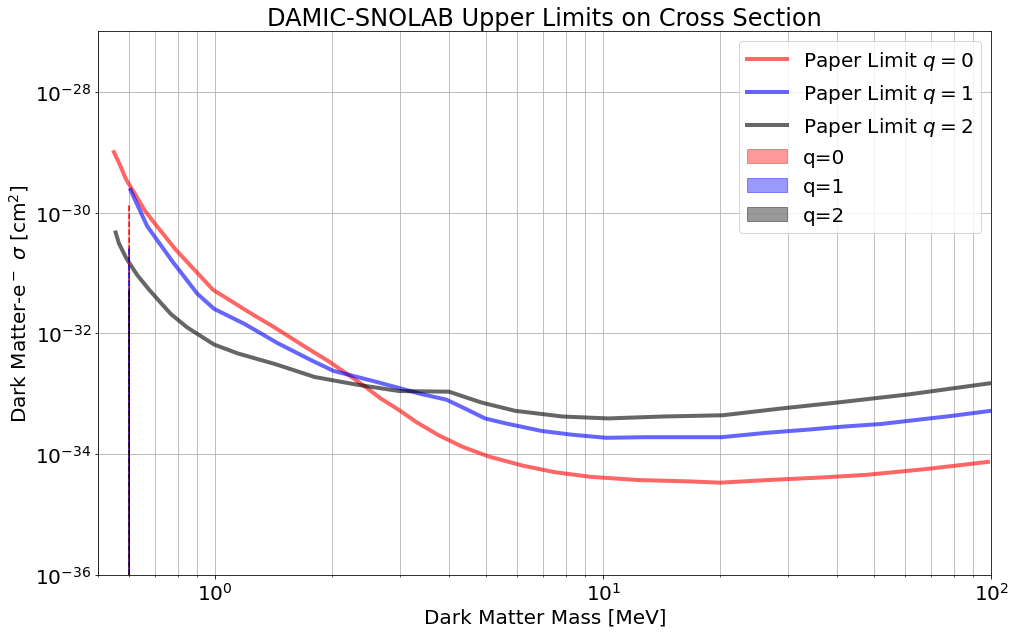

------Mass 0.6841033720647806 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


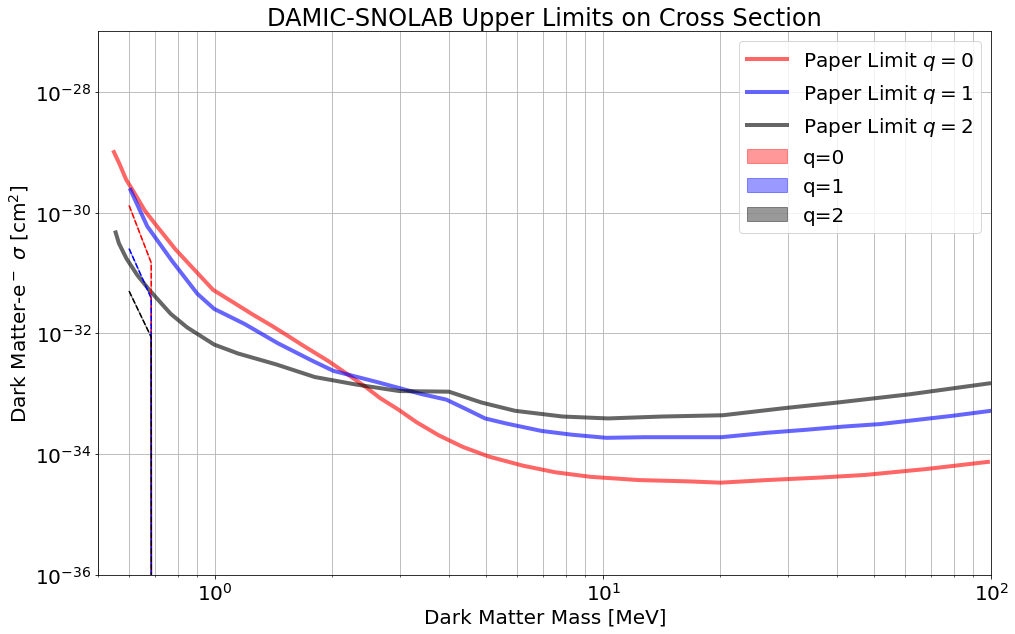

------Mass 0.7799957061173391 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


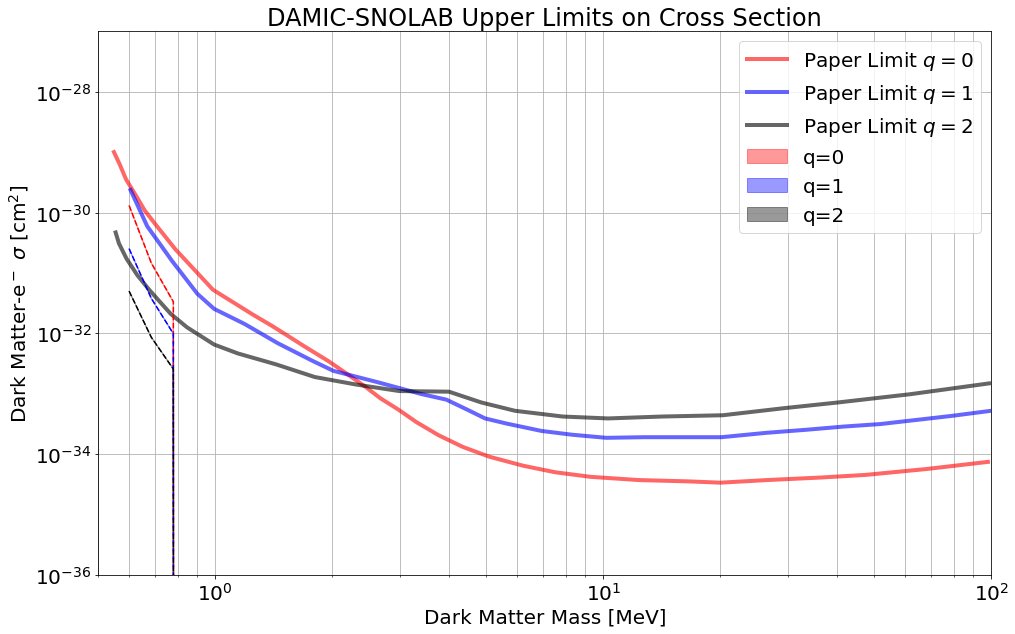

------Mass 0.8893294879182019 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


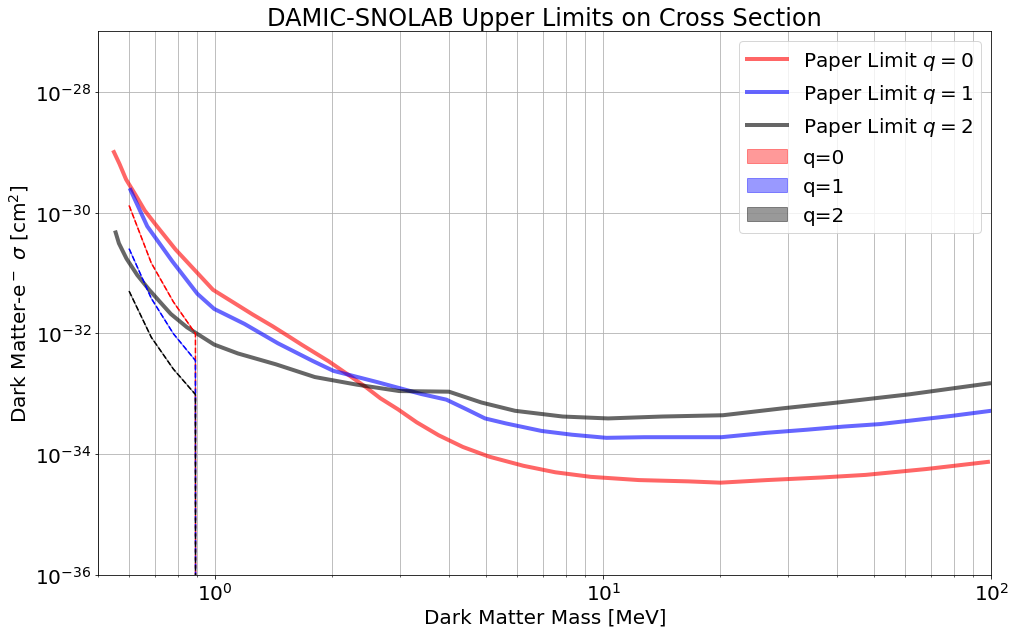

------Mass 1.013988835935811 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


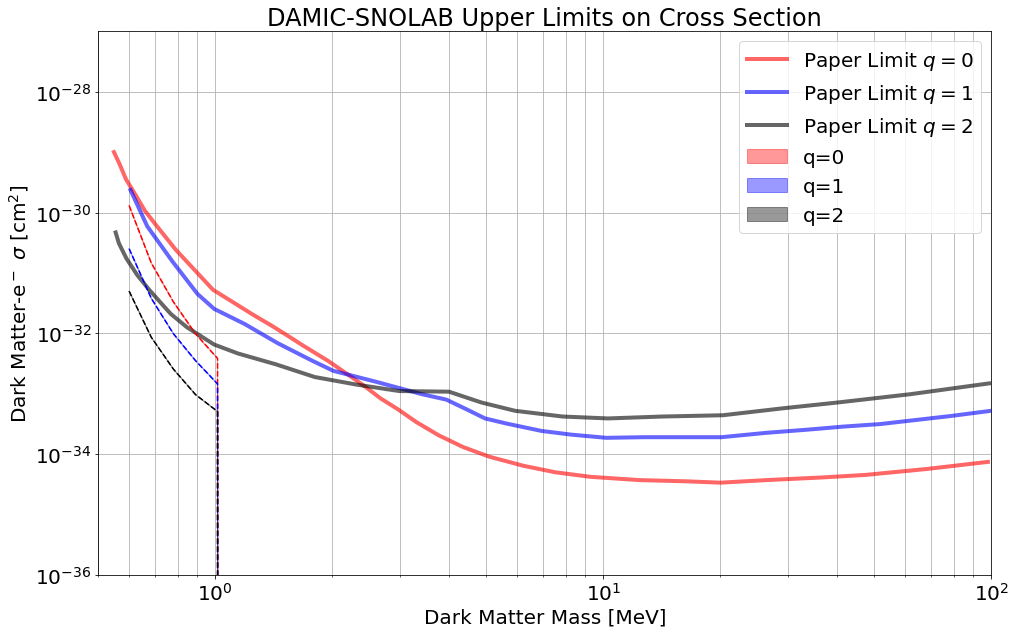

------Mass 1.1561219698328826 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


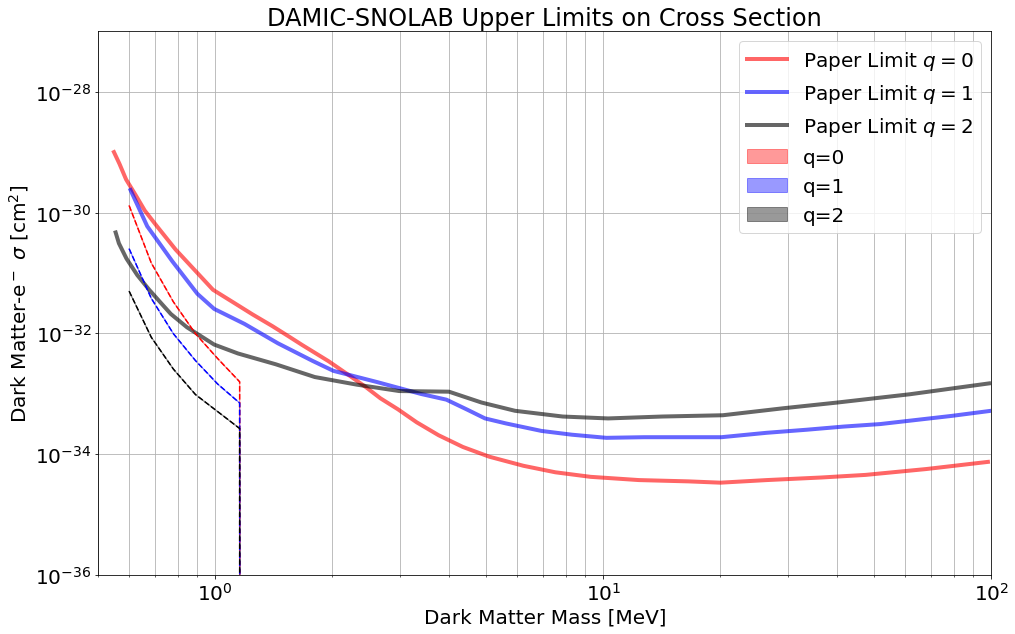

------Mass 1.3181782301347522 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


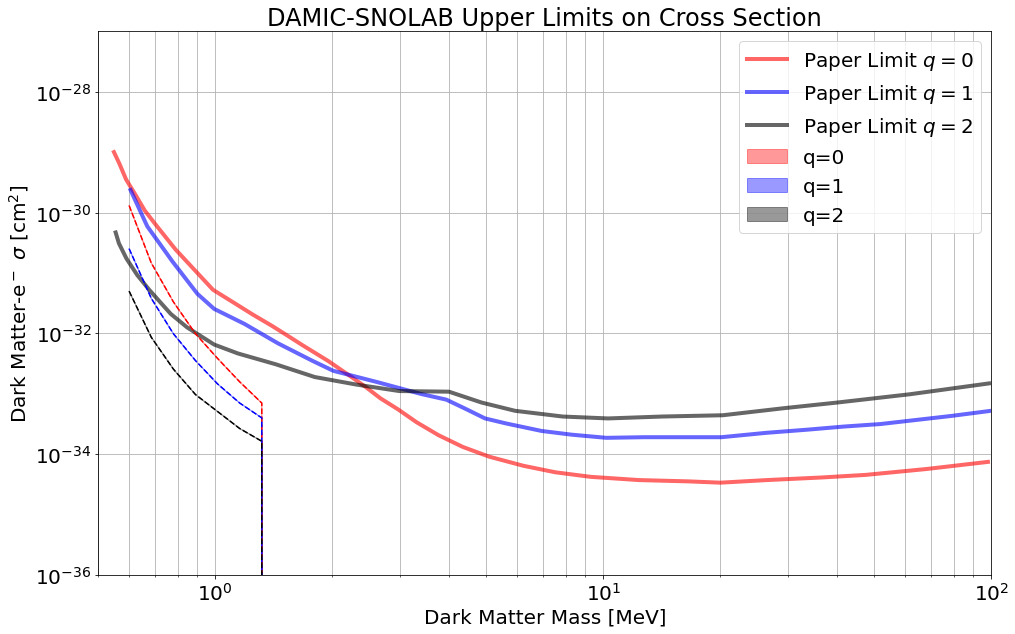

------Mass 1.5029502870292808 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


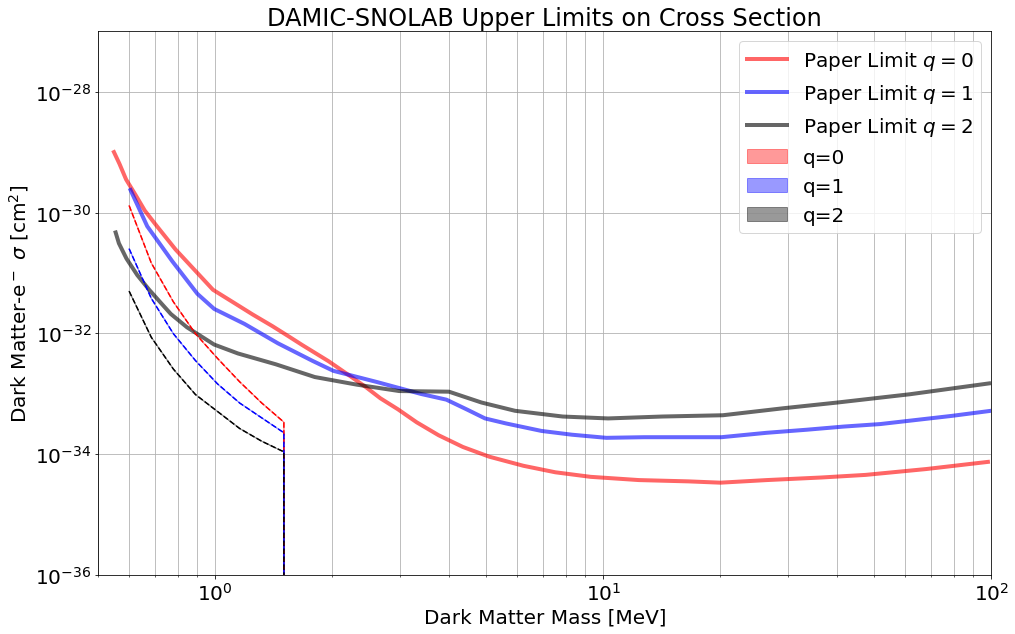

------Mass 1.7136222656707676 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


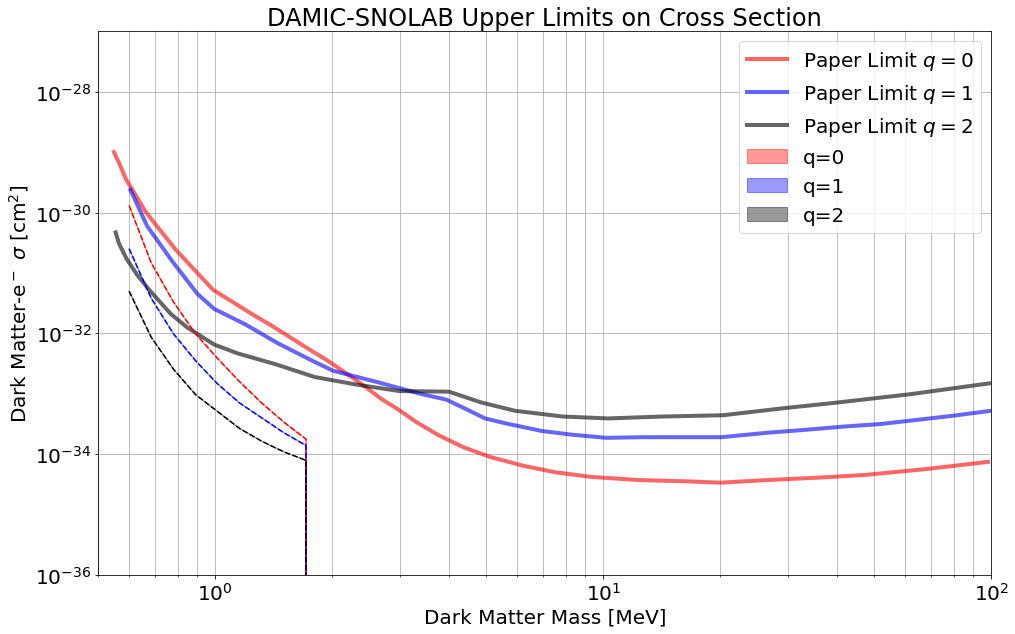

------Mass 1.9538246173177687 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


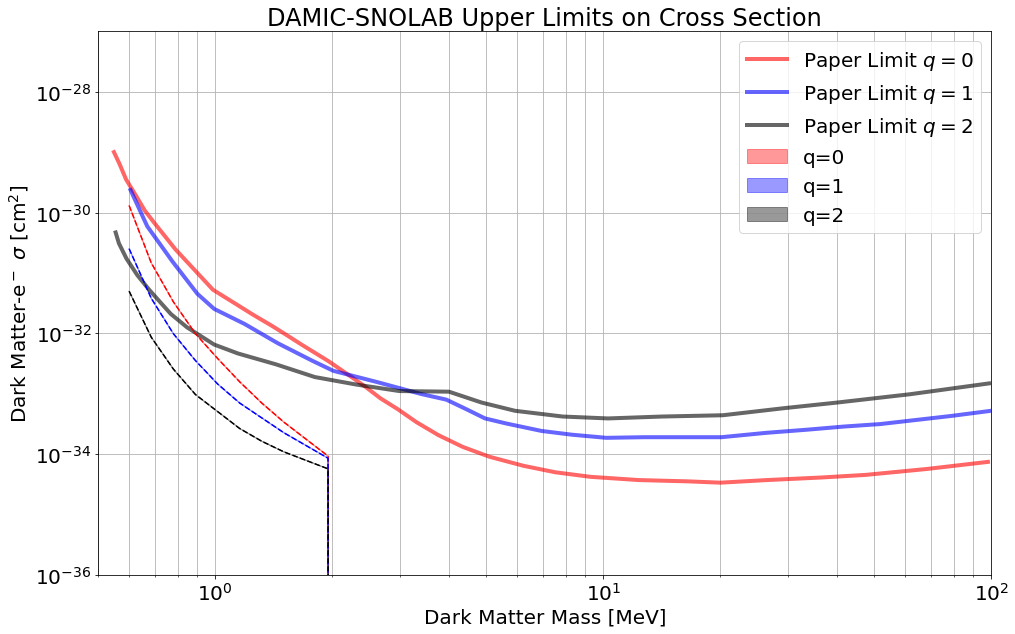

------Mass 2.227696681883775 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


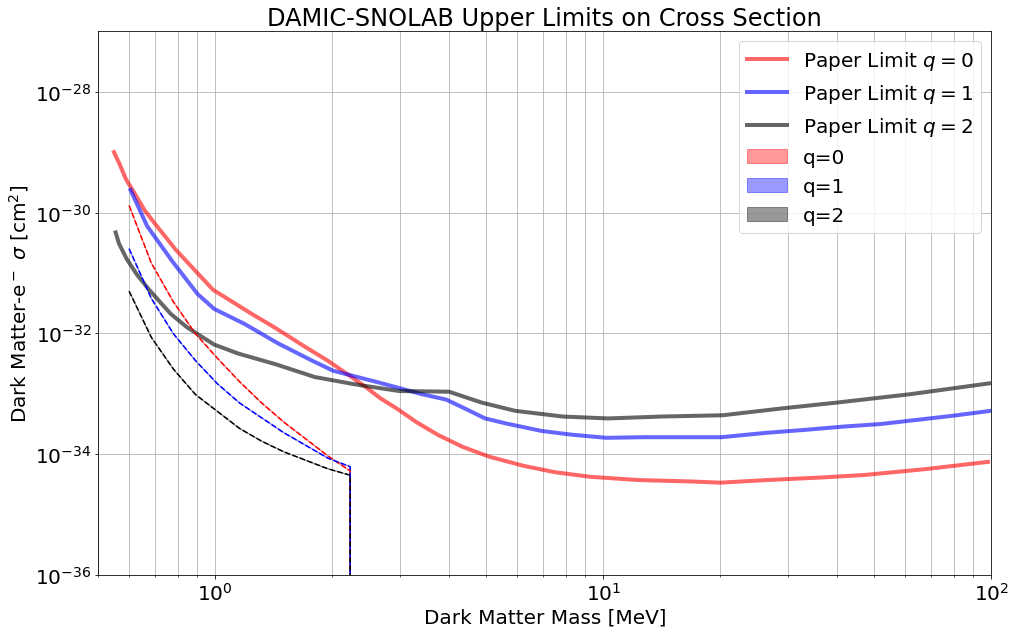

------Mass 2.539958020023688 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


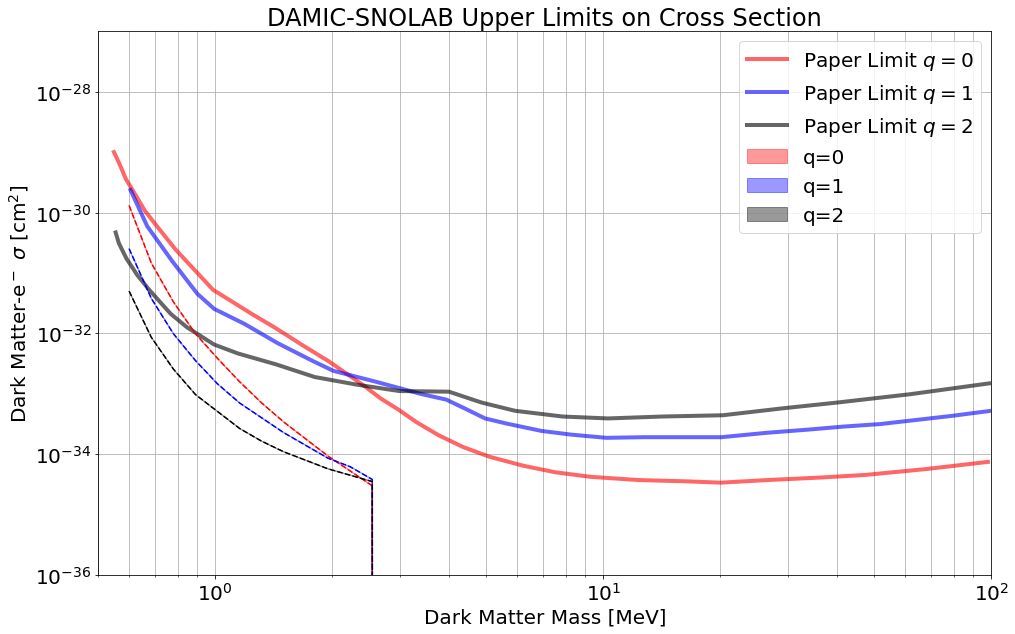

------Mass 2.89598974400198 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


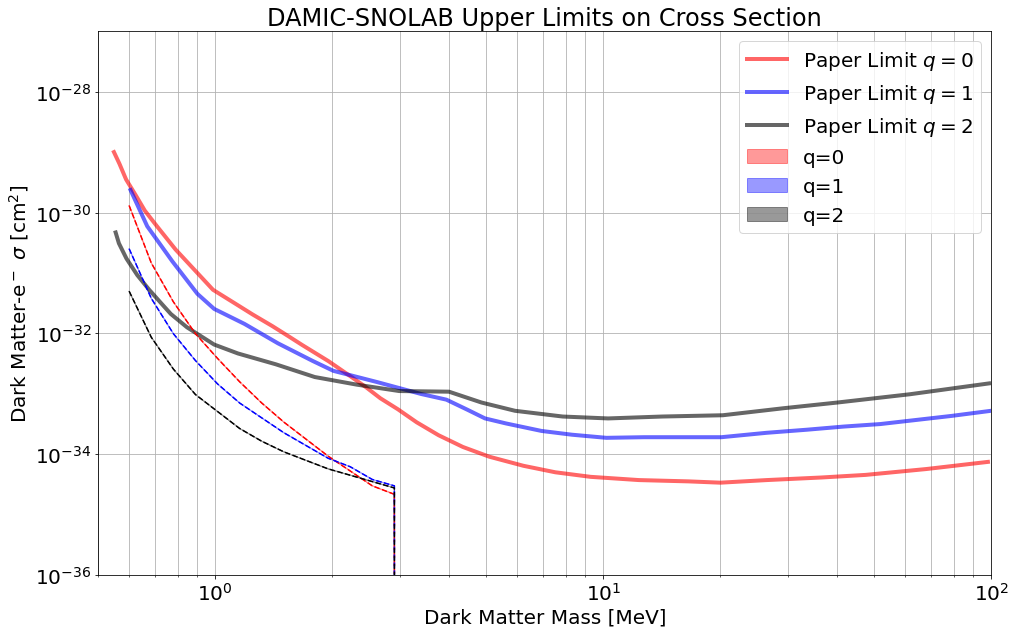

------Mass 3.3019272488946263 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


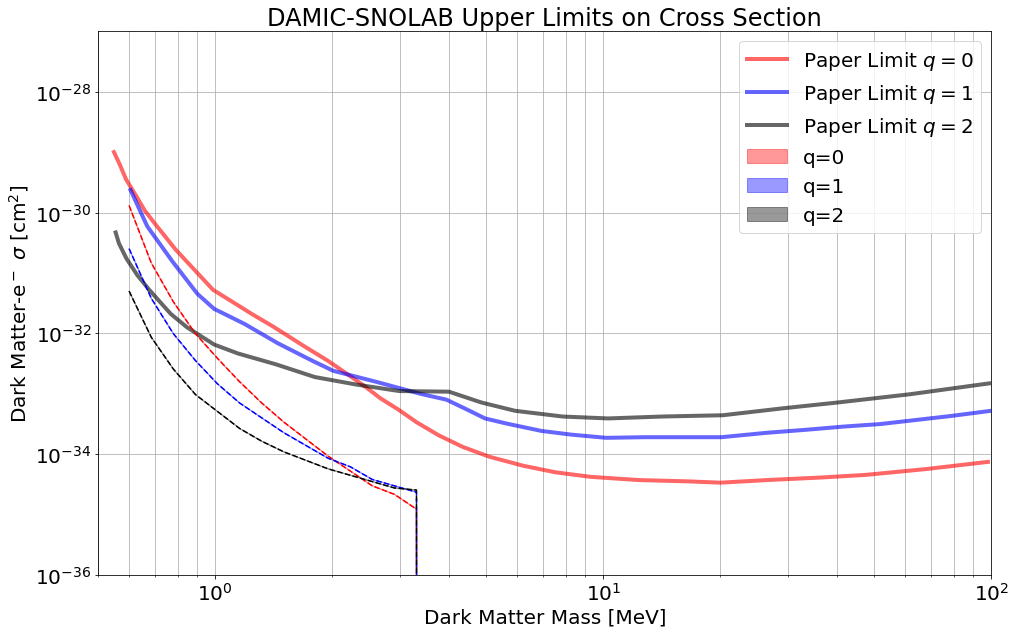

------Mass 3.7647659421356616 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


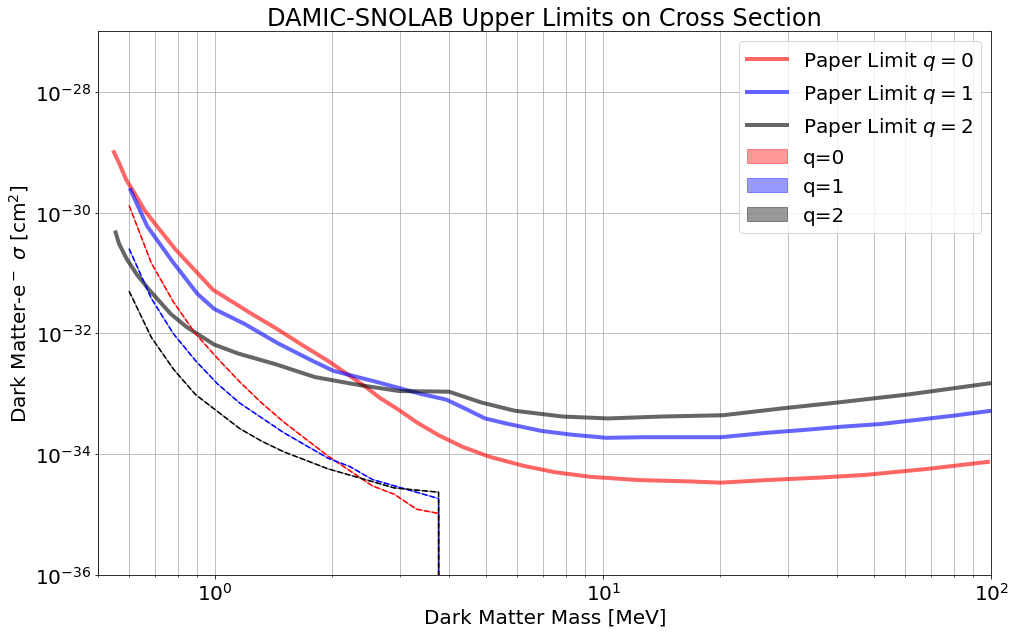

------Mass 4.292481793416078 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


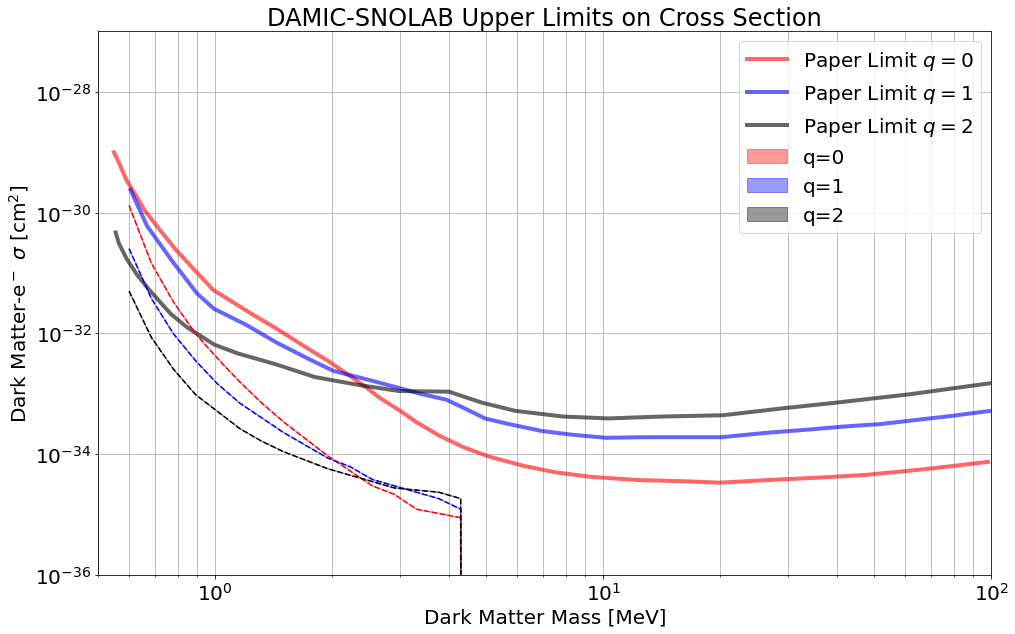

------Mass 4.894168782337692 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


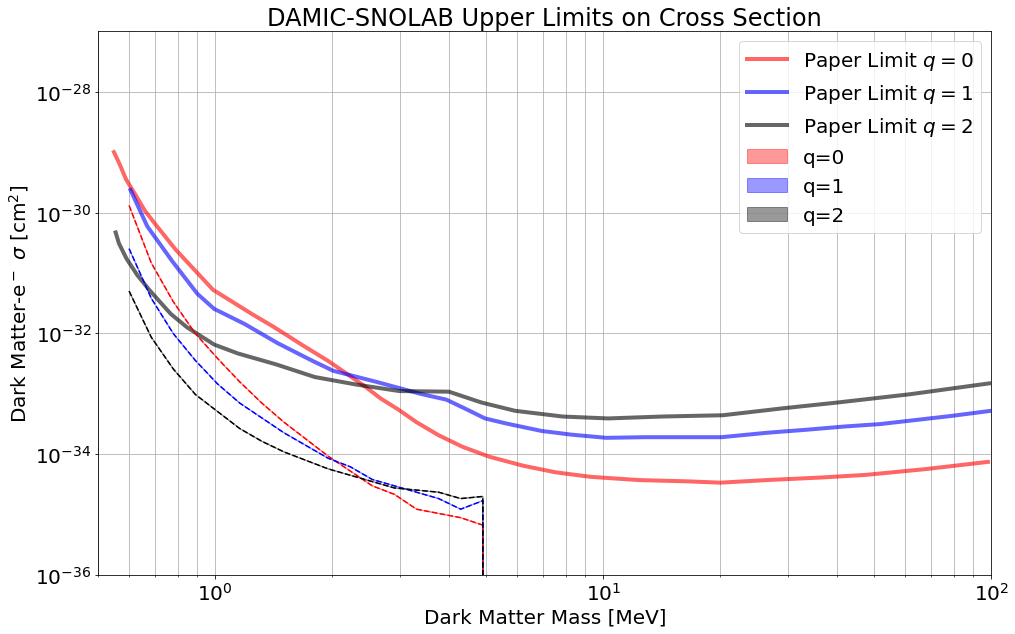

------Mass 5.580195612418992 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


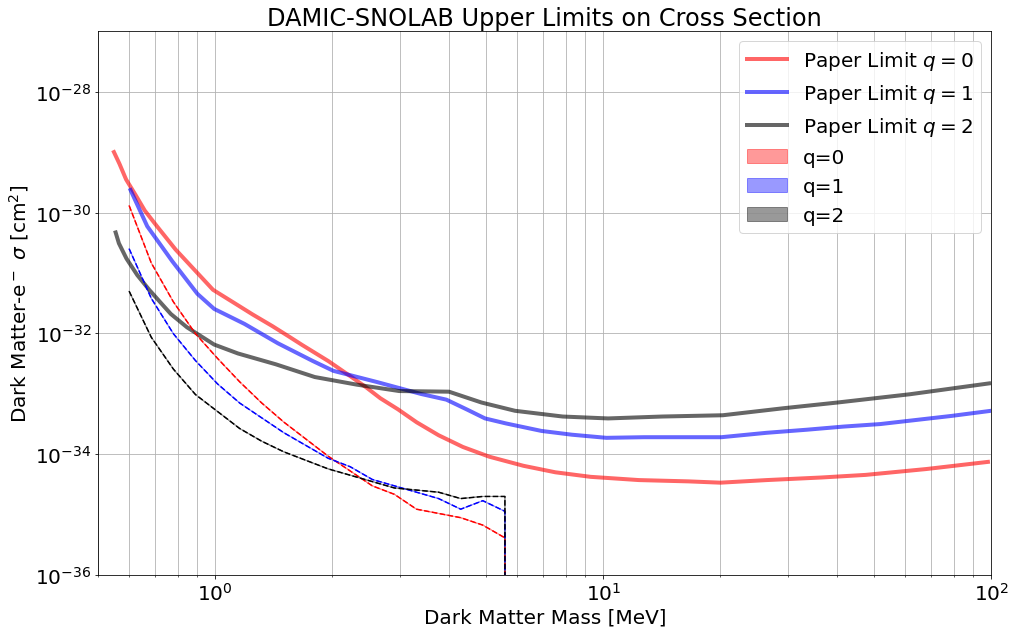

------Mass 6.362384392061543 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


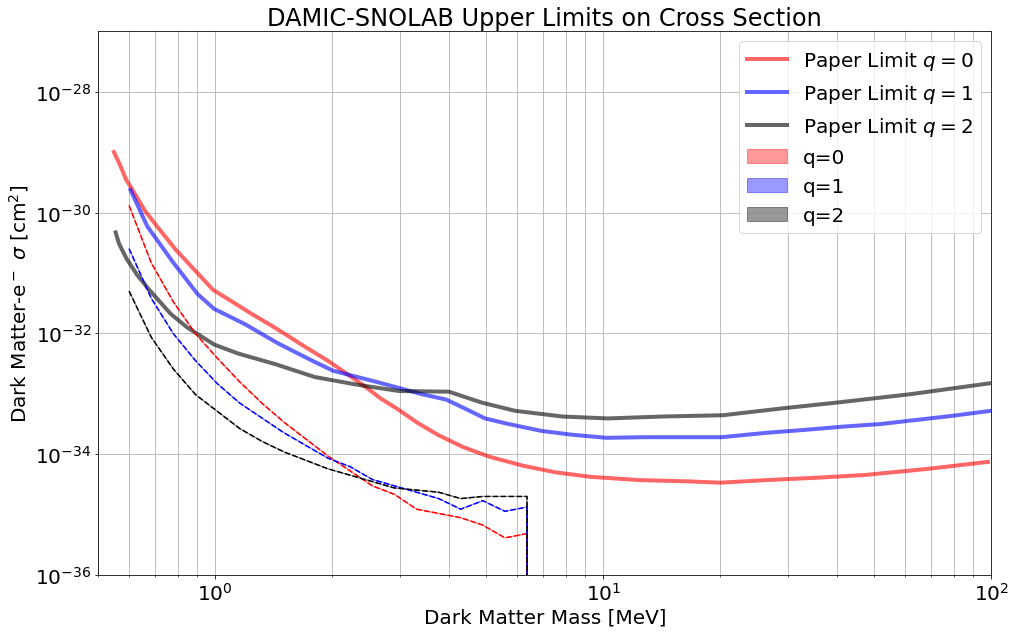

------Mass 7.254214361636051 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


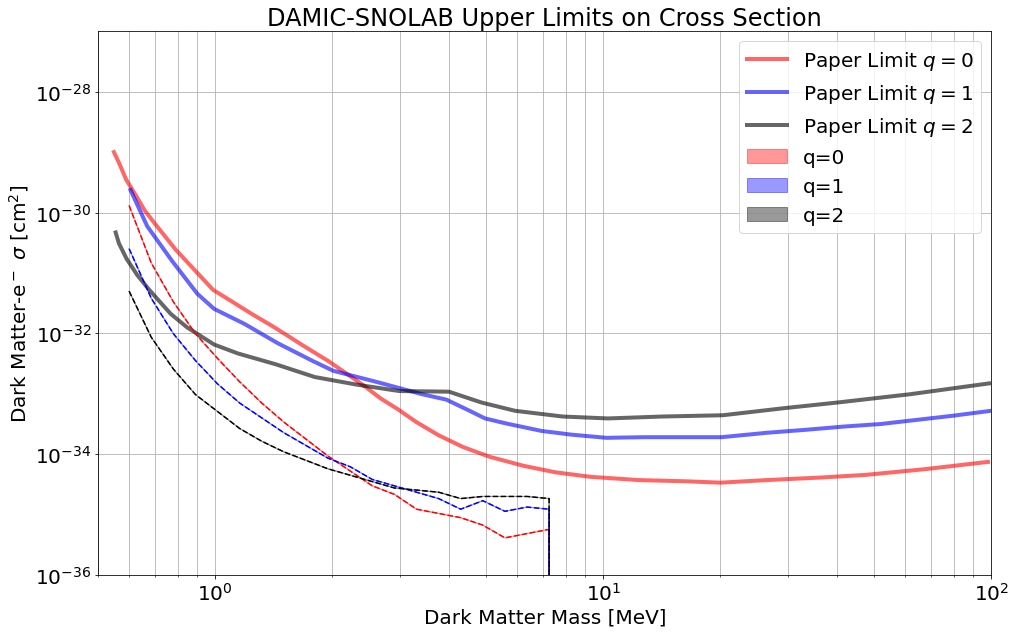

------Mass 8.27105417745997 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


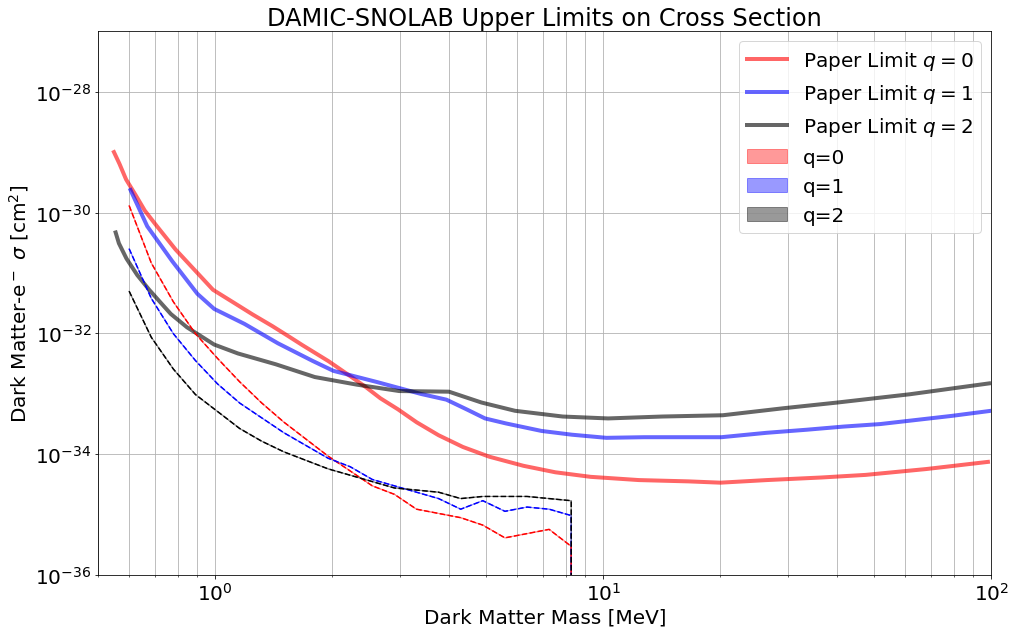

------Mass 9.430426755551421 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


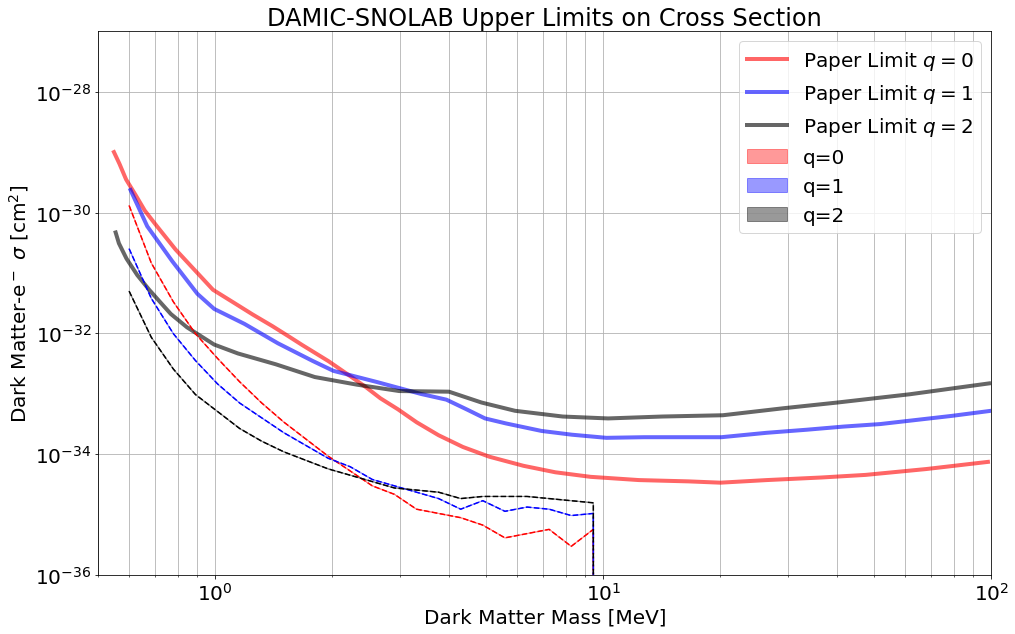

------Mass 10.752311239137759 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


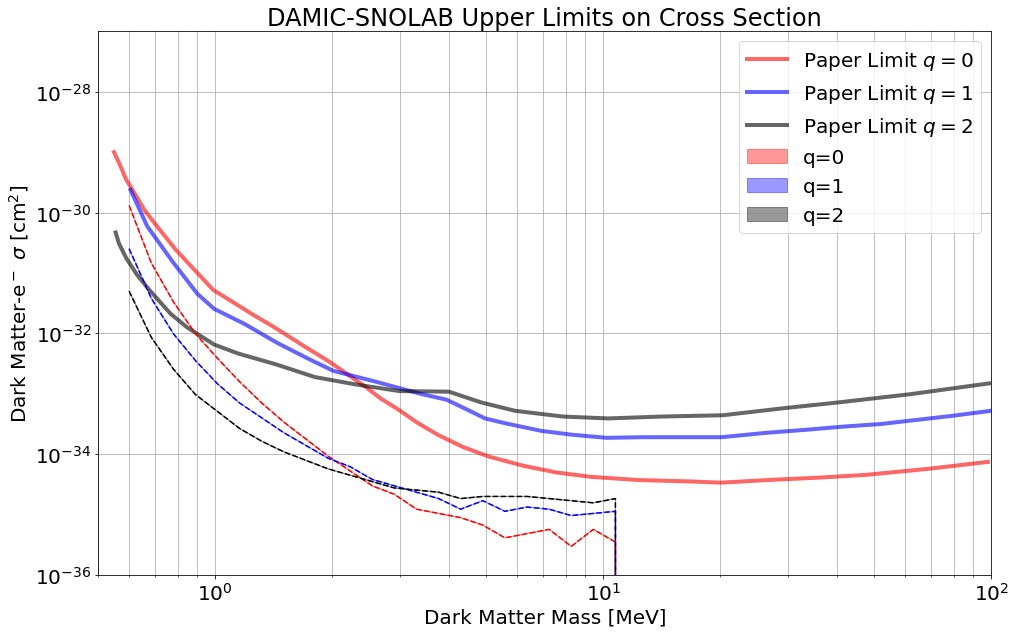

------Mass 12.2594872936403 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


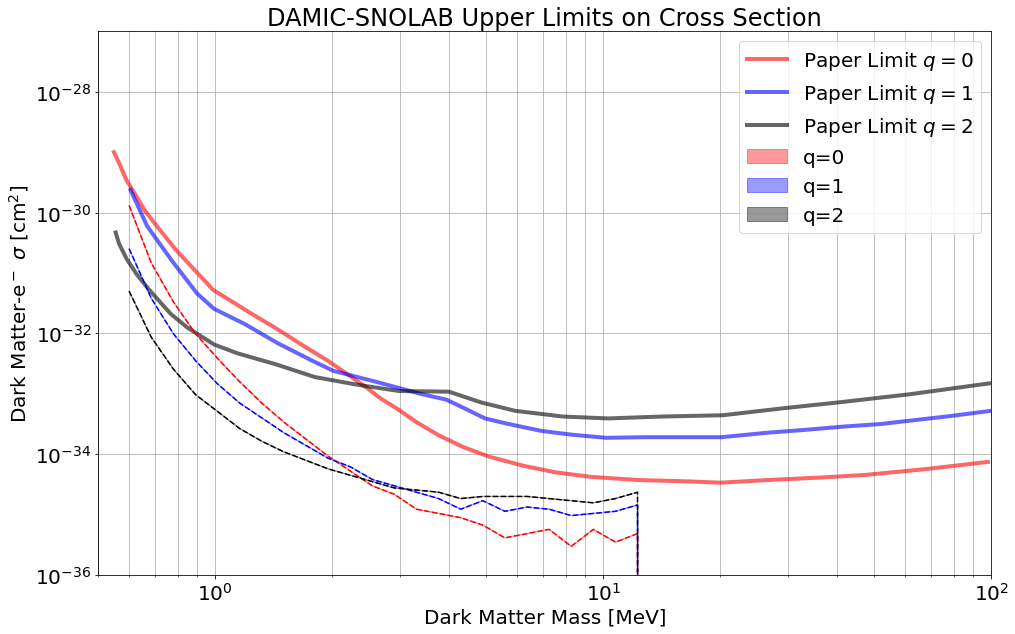

------Mass 13.977927662274427 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


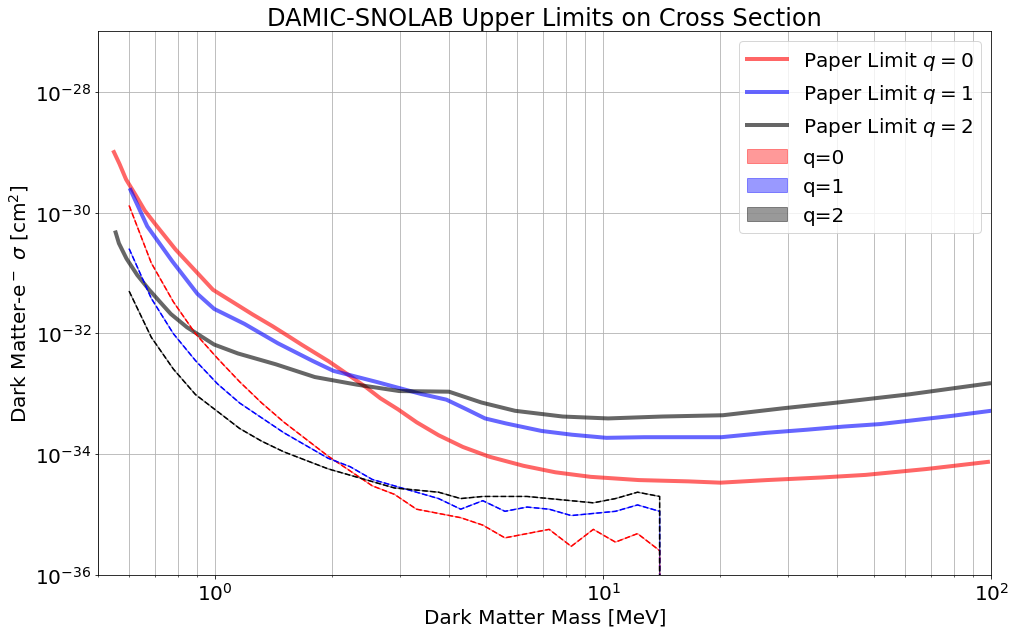

------Mass 15.937245747065852 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


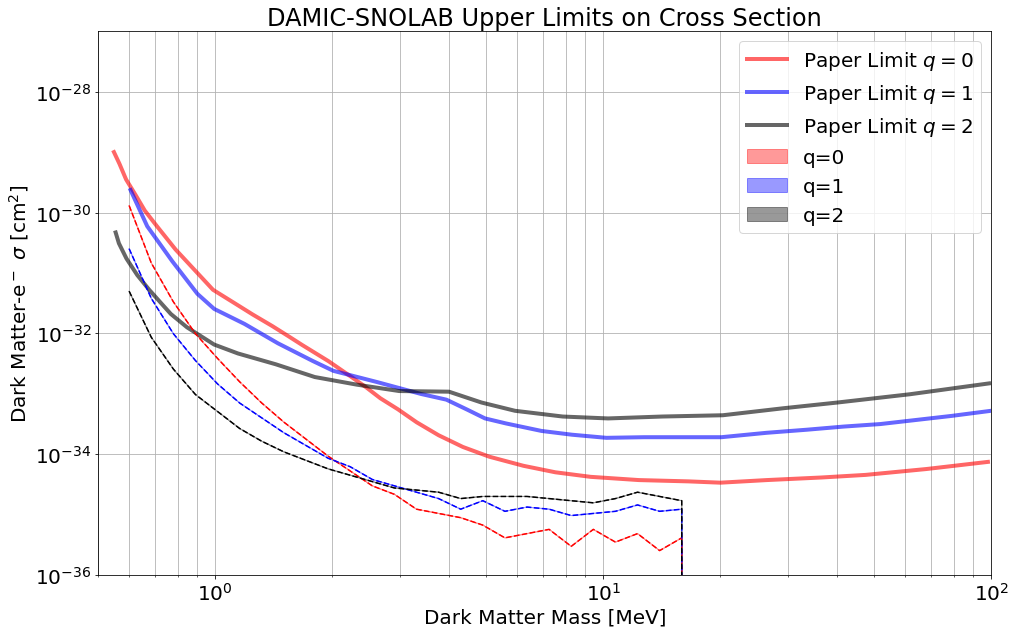

------Mass 18.171205928321392 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


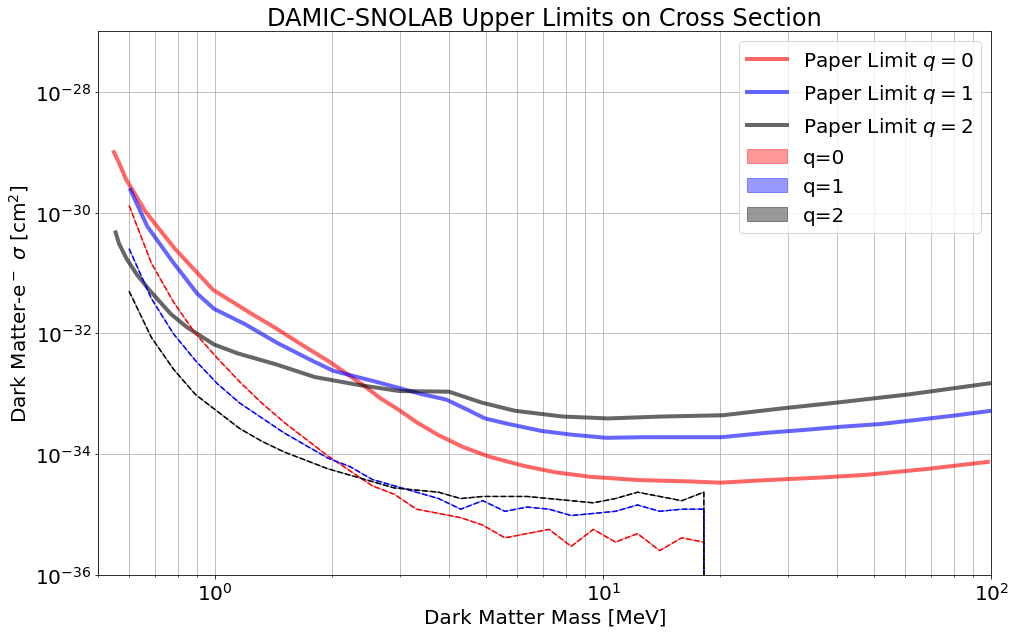

------Mass 20.718305416746993 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


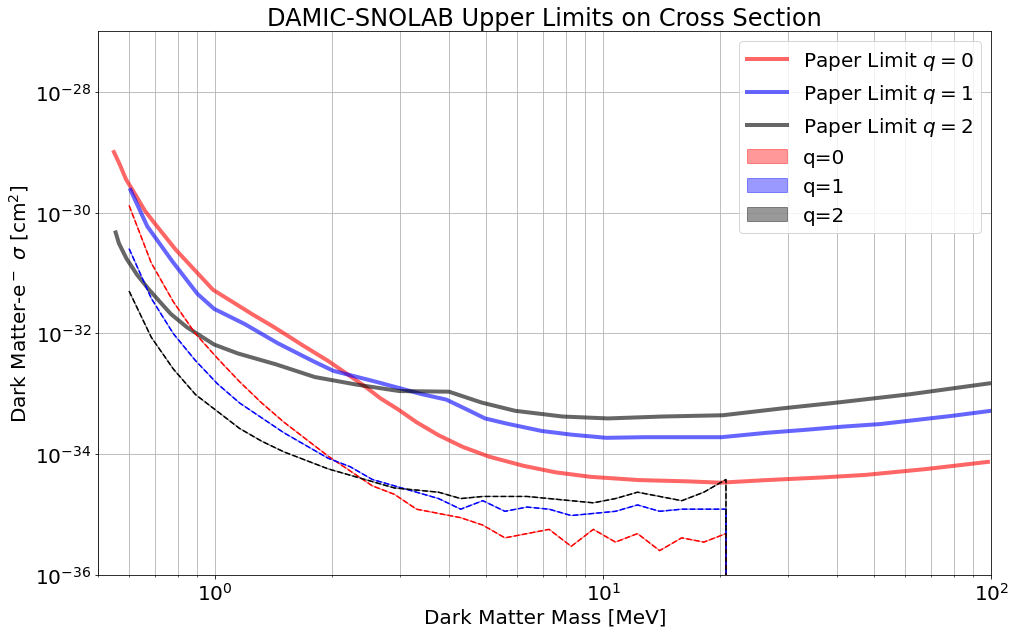

------Mass 23.6224376651077 MeV-------


/home/alantero/repositories/DAMIC_DMe/dm_event.py:318: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


KeyboardInterrupt: 

In [2]:
nxbin = 1
nybin = 100
totrows = 4116
totcols = 4116 #6160
nx = 2500
ny = 4116
mass_ccd = 6e-3
n_images = 38
masked_fraction = (2+0.25)/100
exposuremass = n_images*mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  # grams
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 1e5/(3600)
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 40)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### CCD 3
noise = 1.572
print(t_exp)
dcmm2days = (7.8/t_exp+1.7)+20
dc = dcmm2days*(15*15)*1e-6
mu0 = -0.160

lam = dc*t_exp*nxbin*nybin
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))

#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 4
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

for i,m in enumerate(mass_x):
    print("------Mass {} MeV-------".format(m*1e-6))
    for j in range(n_reps):
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-2,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,1,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_1[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,2,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_2[i][j] = dm.cross_section_dLL

        """
        plt.hist(dm.events, bins = 10, density = False)
        dm = dm_event.dm_event(14, 14, m, dm.cross_section_95, 0.6, 1, True, Eemin=0.06, Eemax=Eemax, eff="efficiency_DAMIC.csv")
        dm.plot_var("dRdE")
        plt.loglog()
        plt.xlim(0.06,1)
        plt.ylim(1e-3,1e2)
        plt.show()
        """
        
    df_inf = pd.read_csv("DAMICSNOLAB_q0.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Paper Limit $q=0$", linewidth=4,alpha=0.6)
    
    
            
    df_inf = pd.read_csv("DAMICSNOLAB_q1.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="b", label=r"Paper Limit $q=1$", linewidth=4,alpha=0.6)
    
                
    df_inf = pd.read_csv("DAMICSNOLAB_q2.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="k", label=r"Paper Limit $q=2$", linewidth=4, alpha=0.6)
    
    
    #df_sup = pd.read_csv("DAMICS_sup.csv", comment="#")
    #x2,y2 = df_sup["mx"],df_sup["xs"]

    #plt.plot(x1,y1, 'o',label="DAMICM Upper Limit Papers")
    #plt.fill(
    #    np.append(x1, x2[::-1]),
    #    np.append(y1, y2[::-1]), color="r", alpha = 0.6, label="DAMIC Paper"
    #)

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")

    xs_mean = np.median(xs_1, axis=1)
    xs_std = np.std(xs_1, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "b")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=1", alpha = 0.4, color = "b")

 
    xs_mean = np.median(xs_2, axis=1)
    xs_std = np.std(xs_2, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "k")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=2", alpha = 0.4, color = "k")

 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-36,1e-27)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

In [ ]:
nxbin = 1
nybin = 10
totrows = 3072*4
totcols = 443*4 #6160
nx = 443
ny = 3072
mass_ccd = 1.926e-3
masked_fraction = (1-(nx-93)/nx)+0.069#(2+0.25)/100
exposuremass = mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  
n_images = int(19.93e-3/(exposuremass*20/24))
print("Number Images: ", n_images)
exposuremass = n_images*exposuremass
print(n_images*nx*ny*(1-masked_fraction))
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 20 #+ 5.153#1e5/(3600)
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 10)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### Quadrant 1
noise = 0.146
print(t_exp)
dcimg = 1.067e-3#dcmm2days*(15*15)*1e-6
dc = dcimg/t_exp
mu0 = 0

lam = dc*t_exp*nxbin*nybin
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
#print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))

#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 4
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

for i,m in enumerate(mass_x):
    for j in range(n_reps):
        print("------Mass {} GeV-------".format(m))
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,1,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_1[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,2,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_2[i][j] = dm.cross_section_dLL

        """
        plt.hist(dm.events, bins = 10, density = False)
        dm = dm_event.dm_event(14, 14, m, dm.cross_section_95, 0.6, 1, True, Eemin=0.06, Eemax=Eemax, eff="efficiency_DAMIC.csv")
        dm.plot_var("dRdE")
        plt.loglog()
        plt.xlim(0.06,1)
        plt.ylim(1e-3,1e2)
        plt.show()
        """
        
    df_inf = pd.read_csv("DAMICSNOLAB_q0.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Paper Limit $q=0$", linewidth=4,alpha=0.6)
    
    
            
    df_inf = pd.read_csv("DAMICSNOLAB_q1.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="b", label=r"Paper Limit $q=1$", linewidth=4,alpha=0.6)
    
                
    df_inf = pd.read_csv("DAMICSNOLAB_q2.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="k", label=r"Paper Limit $q=2$", linewidth=4, alpha=0.6)
    
    
    #df_sup = pd.read_csv("DAMICS_sup.csv", comment="#")
    #x2,y2 = df_sup["mx"],df_sup["xs"]

    #plt.plot(x1,y1, 'o',label="DAMICM Upper Limit Papers")
    #plt.fill(
    #    np.append(x1, x2[::-1]),
    #    np.append(y1, y2[::-1]), color="r", alpha = 0.6, label="DAMIC Paper"
    #)

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")

    xs_mean = np.median(xs_1, axis=1)
    xs_std = np.std(xs_1, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "b")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=1", alpha = 0.4, color = "b")

 
    xs_mean = np.median(xs_2, axis=1)
    xs_std = np.std(xs_2, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "k")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=2", alpha = 0.4, color = "k")

 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-36,1e-27)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

Number Images:  275
269856998.40000004
20
Total Exposure [g*days]:  19.891329059678334
0.8333333333333334
Dark Current [e/pix*days]:  0.0012804
Dark Current [e/pix_binned*days]:  0.012804
Dark Current [e/pix_binned*img]:  0.01067
------Mass 600000.0 GeV-------
Lowest Cross Section:  1e-33
------------ Using Si model -----------
Exposure [g*days]:  19.891329059678334
Number of Total Pixels:  26985700
Number of Signal events:  0
Lamb:  0.01067
Cross 90CF:  -29.7734375
Lowest Cross Section:  1e-34
Lamb:  0.01067
Cross 90CF:  -30.494140625
Lowest Cross Section:  1e-36
Lamb:  0.01067


In [9]:
from scipy.stats import chi2

chi2.ppf(0.9,df=1)/2

1.352771727047702